# NLP - Retail Items classification - Alejandro Duran


---

## 1. Introduction

At Company A we have at our disposal a huge and varied amount of data from items, users, conversations, transactions, etc, and of all types: numerical, categorical, eventual, text and images. Thanks to that, many different valuable data products can be built.

For instance, as part of a Product initiative, the Data Science team is asked to develop a solution to properly classify listings that fall between two categories: **0-Cellphones** and **1-Computers**. We could use a lot of data from existing items (title, description, images, price, and other fields and metadata), but as an MVP, we decide to implement a ML solution based only on text (the items title), and frame it as a **binary classification problem**.

We then build a dataset by querying from the Data Warehouse a sample of 1500 items from these two categories, with their titles (in lower case) and their categories (selected by the users when uploaded). This dataset can be found in the attached file `data.json`.

In the next sections we will tackle the problem with two different approaches to assess the feasibility of the challenge.

## 2. Loading the dataset

First, we begin by loading the dataset. If the file `data.json` is in the same location as this notebook (or a suitable path), you should be able to run the next two cells just fine. Otherwise, if you face any issue, you can copy and paste the data in the `else` statement below.

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# I mount my Google Drive, where I saved the data 
# This step is only for me (Ale), since you (Wallapop) already have the data 
# in your particular location 
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
# Path (data location)
data_file = '/content/drive/MyDrive/Colab Notebooks/Wallapop - Practical Assignment/data.json'

In [5]:
#Loading data
if os.path.exists(data_file):
    print("Loading data from file...")
    with open(data_file) as f:
        data = json.load(f)
       
else:
    print("Loading data from string...")
    # replace next lines with data if needed
    #data = json.loads( ...)

 

Loading data from file...


In [6]:
df = pd.DataFrame.from_records(data)
print("DF shape:", df.shape)
df.head()

DF shape: (1500, 3)


,title,category,category_num
0,xgody smartphone (nuevo),cellphones,0
1,kindle paperwhite segunda generacion,computers,1
2,amplificador de antena nuevo,cellphones,0
3,volante logitech g27,computers,1
4,fitbit alta hr,cellphones,0


#### QUESTION 1: Plot the class distribution of the dataset. What we should consider in terms of balancing?

<Figure size 432x288 with 0 Axes>

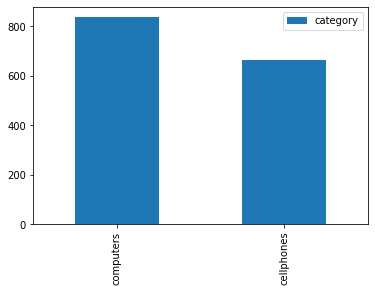

In [7]:
# ANSWER: 
#====== Q1 Class distribution ======
Class_count=df['category'].value_counts().to_frame()

#--Figure 1 - Simple barplot
plt.rcParams['text.color'] = 'black'
fig = plt.figure() 
Class_count.plot(kind='bar')
plt.rc('font', size=15)  
plt.show()


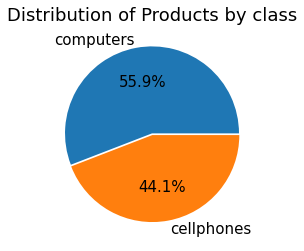

In [8]:
#--Figure 2- Pie chart -> and see category in percentage
fig = plt.figure()
plt.pie(Class_count['category'], labels =[Class_count['category'].index[0],Class_count['category'].index[1]],
        autopct='%1.1f%%',explode = [.02,0])
plt.title('Distribution of Products by class')
plt.show()


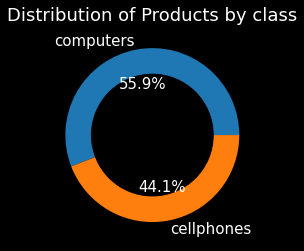

In [9]:
#--Figure 3 (OPTIONAL) Same Piechart but fancier -> Mejor para mostrar
# Set different background
fig = plt.figure()
fig.patch.set_facecolor('black')
plt.rcParams['text.color'] = 'white'
 
# Create a circle at the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='black')

plt.pie(Class_count['category'], labels =['computers','cellphones'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Distribution of Products by class')
plt.show()

## ANSWER (Q1):
Highly unbalanced data will bias an ML model because it will be trained based on the majority class while neglecting the minority one. 

In such scenario one should not use metrics (used to evaluate the model) like *overall mean* or *accuracy*, because it will be affected more by the majority (largest amount) of data.  It is better to use the Confusion Matrix with metrics as *precision* or *recall*, or combine both to compute the *F1 score* . But this depends of course about the specific questions we want to answers. 

In this scenario, I don't observe a high unbalance in the data (a mild unbalance is considered when the minority class is between 20% to 40% of the data. That is not the case here.). Thus, since we are looking to get a MVP, my firts thought is to proceed as it is and quickly evaluate the first classification models.

However, if there is a need we can use resample techniques to get comparable samples. For instance, I can undersample the most common class (*computers*) or oversample the less common class (*cellphones*). I can do this by using random sampling for the given classes. Bellow I give an example, where I overpsample the *cellphones* class using resample from scikit learn.

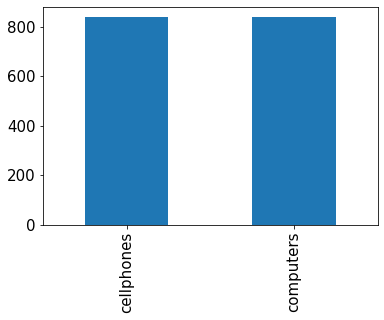

In [10]:
from sklearn.utils import resample
#create df of majority and minority class 
df_majority = df[(df['category_num']==1)] 
df_minority = df[(df['category_num']==0)] 

# Oversampling minority class
df_minority_ovsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= Class_count['category'][0], # match nb computers = nb celphones
                                 random_state=1)  # set a seed for reproducible results
# Concatenate both
df_ovsampled = pd.concat([df_minority_ovsampled, df_majority])

# plot
df_ovsampled['category'].value_counts().plot(kind='bar')
plt.show()

## 3. Splitting the dataset

We proceed to split the dataset in two sets: train and test.

In [11]:
#Optional 
#Using the oversampled data increases RF classification accuracy in ~5% 
#df = df_ovsampled 

# --Splitting the dataset (train=80% test=20%)
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(df["title"], df["category_num"], test_size=0.2, random_state=42)
print("Train size: {}".format(df_train.shape[0]))
print("Test size: {}".format(df_test.shape[0]))

Train size: 1200
Test size: 300


## 4. Training

As mentioned in the introduction, we will try to solve the problem with two different approaches.

### 4.1. Random Forest with word vectors

We build a TF-IDF vectorizer from the dataset...

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500, stop_words=stopwords.words('spanish'))
vectorizer.fit(df["title"])

X_train = vectorizer.transform(df_train)
X_test = vectorizer.transform(df_test)

# print(vectorizer.get_feature_names())  # To check most frequent words
# print(X_test.toarray())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


And train a Random Forest model:

#### QUESTION 2: Train a RandomForest classifier with Scikit-learn.
First, I trained the model using RandomForestClassifier from sklearn. Then, I used the RF model to predict some classes (either *computer* or *cellphone*) by using the test data.


In [13]:
# ANSWER:
# ====== Q2. Train a RandomForest classifier with Scikit-learn ======
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state =0)
rf_classifier.fit(X_train,y_train)

# Predicted output
y_pred = rf_classifier.predict(X_test)

Since an important part of the random forest algorithm is to use appropiate parameters, I decided to make a cross-validation procedure using GridSearchCV to tune those parameters. 

I chose two parameters of interest: 
*   n_estimators -> number of trees in the RF
*   max_depth -> maximum depth of the trees




In [14]:
parameters = { 
    "n_estimators":[50,100,200,300],
    "max_depth":[8,16,32,None]
    }

The GridSearchCV would test those parameters in 5 rounds  (`cv=5`) and output the mean and standard deviation. This gives me an indicator about the range in which I can use those parameters.  The cross-validation gives me a clear result that  `max_depth=None` is the best option. However, regarding the `n_estimators` there are no large differences. I will assess the model performance in the next item.  

In [15]:
# Optional - tunnig parameters via cross-validation
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rf_classifier,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())


# Function for cross-validation
def tune_test(results):
    print(f'Best parameters: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
        
        
tune_test(cv)

Best parameters: {'max_depth': None, 'n_estimators': 300}


0.787 + or -0.023 for the {'max_depth': 8, 'n_estimators': 50}
0.787 + or -0.027 for the {'max_depth': 8, 'n_estimators': 100}
0.793 + or -0.025 for the {'max_depth': 8, 'n_estimators': 200}
0.792 + or -0.027 for the {'max_depth': 8, 'n_estimators': 300}
0.812 + or -0.018 for the {'max_depth': 16, 'n_estimators': 50}
0.815 + or -0.025 for the {'max_depth': 16, 'n_estimators': 100}
0.81 + or -0.028 for the {'max_depth': 16, 'n_estimators': 200}
0.807 + or -0.023 for the {'max_depth': 16, 'n_estimators': 300}
0.827 + or -0.025 for the {'max_depth': 32, 'n_estimators': 50}
0.831 + or -0.023 for the {'max_depth': 32, 'n_estimators': 100}
0.827 + or -0.025 for the {'max_depth': 32, 'n_estimators': 200}
0.833 + or -0.025 for the {'max_depth': 32, 'n_estimators': 300}
0.844 + or -0.027 for the {'max_depth': None, 'n_estimators': 50}
0.838 + or -0.025 for the {'max_depth': None, 'n_estimators': 100}
0.847 + or -0.025 for the {'max_dep

#### QUESTION 3: Assess the performance of this approach.

#### Answer: 
An useful way to assess the performance of a binary clasiffier is by computing a confusion matriz. This will tell how often the classifier was correct. 

These are the main metrics to check

* Accuracy: indicates in general how often the classifier is correct. This is, the total number of correct predictions divided by the total number of predictions. It is not a good metric for unbalanced data as I mentioned before.
* Precision: when the model predicts positive, it indicates how often it is correct
* Recall or sensitivity: It indicates the probability of detection
* F1 Score: is the weighted average of Precision and Recall
 
These metrics are computed based on the number of true/false positives and negatives. In this context, negative corresponds to the label of 0->Cellphones and positive to 1->Computer.  

Bellow I compute the confussion matrix and make a quick analysis for the current case. 

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       130
           1       0.86      0.88      0.87       170

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300

Accuracy is:  0.85


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


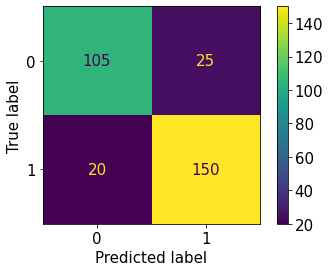

In [16]:
# ANSWER:
# ====== Q3. RF Model performance  ======

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy is: ',accuracy_score(y_test,y_pred))

plot_confusion_matrix(rf_classifier, X_test, y_test)
plt.show()

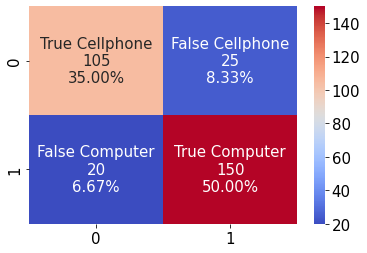

In [17]:
# OPTIONAL - Nicer ConfMatrix Plot
import seaborn as sns

cf_matrix=confusion_matrix(y_test, y_pred)
    
group_names = ['True Cellphone','False Cellphone','False Computer','True Computer']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')

In [18]:
#Balanced accuracy (BA), .i.e. Probability of correct classification (PCC)
BA = 0.5*( (cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0]))
           + (cf_matrix[0][0]/(cf_matrix[0][0]+cf_matrix[0][1])) )
print(BA)

0.8450226244343891


## Main points to consider  (Answer Q3)


1.   Both classes are classified with similar values of precision (aprox 0.85) and recall. F1 score is a good metric for unbalanced data, usually a F1 above 0.8 is considered good and the one obtained here was above that value for both classes. Similarly happend with the obtained values for recall and precision. Thus, I consider the model works reasonable well. However, the specific threshold we target depends on the application and expectation. I mean, if we are classifying medical data this model probably doesn't satisfy the requirements.

2.   85% of data is properly clasiffied. However, it is important to identify the cost of a wrong classification. For instance, is it more costly to clasiffy wrongly a computer as a cellphone or the other way around? I would argue that this is the case since usually a computer is more expensive. Then, packing/selling a computer with the price of a cellphone might be a bigger problem. But this depends on the specific application. 

3. Instead of evaluating the result using a standard ROC-AUC I used a simpler approach that is easier to interpret. I computed the Balanced accuracy (also known as Probability of correct classification PCC ). This metric is useful for unbalanced data. I got BA = 0.85 , meaning that there is a probability 85% of correct classification. In this case, this matches the overall acuracy. 


4. The original dataset is unbalance. When I trained the model after oversampling the minority data (check box [10] of this notebook) the RF classification accuracy increases by ~5%. You can quikly do this by uncommented the 1st lines in box [11] (`df = df_ovsampled`)and run the model again. This is a simple approach to increase the performance and get ~90% accuracy. This improvement is also observable in the other metrics (F1-score, prec,recall). 


### 4.2. Recurrent Neural Network (LSTM) with word embeddings

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Embedding, LSTM, Dense

In [20]:
max_words = 500
max_length = 10
embedding_dim = 50
batch_size = 32
num_epochs = 15

We begin by building a Keras word Tokenizer:

In [21]:
tokenizer = Tokenizer(num_words=max_words, oov_token=1)
tokenizer.fit_on_texts(df_train)

X_train = tokenizer.texts_to_sequences(df_train)
X_train = pad_sequences(X_train, maxlen=max_length)

X_test = tokenizer.texts_to_sequences(df_test)
X_test = pad_sequences(X_test, maxlen=max_length)

:#### QUESTION 4: What is the parameter `oov_token=1` in the cell above? What is its purpose?

### ANSWER Q4: 
OVV means *Out Of Vocabulary*.This parameter `oov_token` is used for replacing any unknown words (not present in our corpus) with a token. For instance, if I use `oov_token='Barça'` the code will replace unkown words by the string *'Barça'*. In the current code we are replacing unkown words with a number `oov_token=1`.
Using `oov_token` to assign a token instead of throwing away unknown words might be a good approach, since we can use these information in the model instead of neglecting it. 

We then train a simple RNN LSTM architecture:

In [22]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=50, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test)
)

Epoch 1/15
38/38 [==============================] - 4s 28ms/step - loss: 0.6734 - accuracy: 0.5683 - val_loss: 0.6255 - val_accuracy: 0.6267
Epoch 2/15
38/38 [==============================] - 0s 11ms/step - loss: 0.5289 - accuracy: 0.7675 - val_loss: 0.4455 - val_accuracy: 0.7967
Epoch 3/15
38/38 [==============================] - 0s 11ms/step - loss: 0.3859 - accuracy: 0.8508 - val_loss: 0.3575 - val_accuracy: 0.8500
Epoch 4/15
38/38 [==============================] - 0s 11ms/step - loss: 0.3161 - accuracy: 0.8775 - val_loss: 0.3201 - val_accuracy: 0.8767
Epoch 5/15
38/38 [==============================] - 0s 11ms/step - loss: 0.2765 - accuracy: 0.8883 - val_loss: 0.3107 - val_accuracy: 0.8867
Epoch 6/15
38/38 [==============================] - 0s 11ms/step - loss: 0.2543 - accuracy: 0.9017 - val_loss: 0.3031 - val_accuracy: 0.8833
Epoch 7/15
38/38 [==============================] - 0s 11ms/step - loss: 0.2406 - accuracy: 0.9042 - val_loss: 0.3358 - val_accuracy: 0.8467
Epoch 8/15
38

And plot the training history:

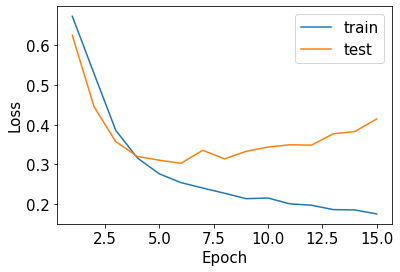

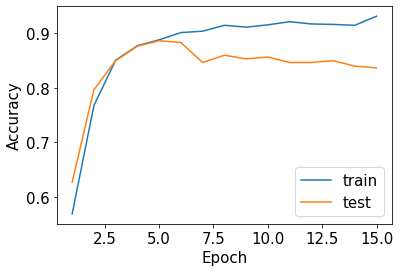

In [25]:
epochs = range(1, num_epochs+1)
plt.rcParams['text.color'] = 'black'

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(epochs, history.history["loss"], label="train")
plt.plot(epochs, history.history["val_loss"], label="test")
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(epochs, history.history["accuracy"], label="train")
plt.plot(epochs, history.history["val_accuracy"], label="test")
plt.legend(loc='lower right')

plt.show()

#### QUESTION 5: What can you say about the training of this model?

### Answer Q5:
The figures show how the loss function and the accuracy of the model evolve with each epoch for the two datasets: train and test(i.e.,validation).   I see that for the training data the values for accuracy and loss are favorable (higher accuracy and lower loss) , but it is **not** the case for the testing data. In fact, the behavoiur of train and test is diverging. This is an indication of overfitting. The model fits very well the training data but it doesn't generalize well and therefore outperforms with new data that hasn't seen before (test data).

#### QUESTION 6: Assess the performance of this approach. How could you compare it to the first approach? In a follow-up meeting for this project you are asked to give an estimate of the performance we can expect to have with this model. How would you assess it?

### Answer Q6:
The first step is to see the performance of the current LSTM model and then to compare it to the previous approach (RF model).
Regarding the LSTM model, I can use the same metrics used before (acc, F1-score, recall and precision): 

              precision    recall  f1-score   support

           0       0.89      0.72      0.79       130
           1       0.81      0.93      0.87       170

    accuracy                           0.84       300
   macro avg       0.85      0.82      0.83       300
weighted avg       0.84      0.84      0.83       300

Accuracy is:  0.8366666666666667
Balanced accuracy is  0.8223981900452488


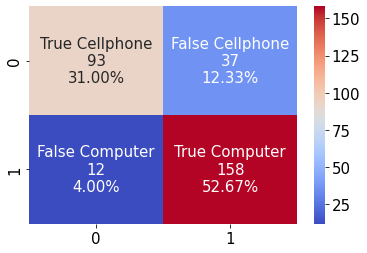

In [26]:
# ANSWER Q6:
#-- Predictions 
y_pred = np.round(model.predict(X_test)) 


print(classification_report(y_test, y_pred))
print('Accuracy is: ',accuracy_score(y_test,y_pred))

cf_matrix=confusion_matrix(y_test, y_pred)
    
#group_names = ['True Neg','False Pos','False Neg','True Pos']
group_names = ['True Cellphone','False Cellphone','False Computer','True Computer']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm') #Blues coolwarm rocket
  

#Balanced accuracy (BA), .i.e. Probability of correct classification (PCC)
BA = 0.5*( (cf_matrix[1][1]/(cf_matrix[1][1]+cf_matrix[1][0]))
           + (cf_matrix[0][0]/(cf_matrix[0][0]+cf_matrix[0][1])) )
print('Balanced accuracy is ', BA)

### Assesment of the LSTM model:
Using the same metrics as before I got 83% accuracy and 82% in balance accuracy. Precision, recall and F1-score have similar values but the performance for the minority of data (*cellphones* = 0 class) is lower comparing to the majority of data (*computers* = 1 class) . This happened also for the RF model and it is a footprint of the fact that this is unbalanced data. 


### Assessment/Comparison between models and Performance estimation:
Overall, the metrics in the previous step show a similar performance between both models. However, to really obtain a structured estimation of their performance and also a clear comparison it is better to perform a more robust statistical approach.

I propose to perform a k-fold cross-validation on each on the models. This means, dividing the data set (Xvalidate and Xtrain) and running the training k-times (k=10 for instance) each time shifting the selection of the validation data. Thus, all data will be use for train and test. The final metrics will be the average along all iterations. This allow me to compare both models. 

Example: *Avg[metric RF_Model]*  >  *Avg[metric LSTM_Model]*  =>
If the metric here is the F1-score, then I can say RF performs better than LSTM model.

Goind deeper in the comparison I can also use the k-samples obtained from both models and perform a t-test to say if the differences of both model metrics have a statistical significance.


#### Performance
To estimate the model performance I can use the k-fold cross-validation approach I just mentioned. But it is better to have three sets of data: Xtrain, Xvalidate (the one used to validate the model with unkown data and used as indicator to tune the parameters), Xtest (final test, acting as model performance estimation with the 'real world'). With two sets only I don't have any independent data (since all was used in the k-fold CV) to be used as feedback mechanism for checking the model performance.




#### QUESTION 7: Retrieve some examples of mistakes made by the model. What can you say about them?


#### Answer Q7:
I observed that the model performes better when classifying computers and it makes more mistakes when classifying cellphones. This can be seen from the confusion matrix of the previous section. 

Bellow I make some plots that also show this effect. Whenever the model makes a mistake, it is more likely that it is an error in classifying cellphones.
I think this is a concequence of the unbalance of data since when I run the model after balancing it I see a reduction in this effect. In general, a better model would require larger data sets with high quality labels.

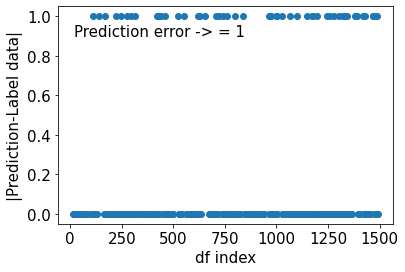

                                          title    category  category_num
741                       blackberry 8520 libre  cellphones             0
1382   da vida a tu móvil cambiando la batería.  cellphones             0
1199              altavoz bluetooth impermeable  cellphones             0
1419                           servicio técnico  cellphones             0
432                          caja iphone 6nueva   computers             1
1470  aire acondicional personal nuevo + regalo  cellphones             0
1281                                      vendo  cellphones             0
220                             batería samsung  cellphones             0
1391                   apple watch serie4, 44mm  cellphones             0
439         playstation 4 gold wireless headset   computers             1


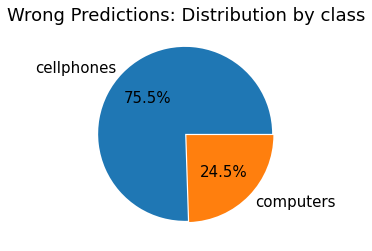

In [27]:
# ANSWER Q7: 
# -- Errors in the model--

#index of the test data in the df
idx_test = y_test.index.values 

#diff between prediction and test data
diff = np.abs(y_test-y_pred.reshape(300,))

wrong_pred_idx = np.where(diff==1)
wrong_pred_idx = idx_test[wrong_pred_idx] #wrong pred using original df indx

#--Figure
plt.scatter(idx_test,diff)  #0->match     1->missmatch, wrong prediction
#plt.xlim([25, 50])
plt.ylabel('|Prediction-Label data|')
plt.xlabel('df index')
plt.text(19, 0.9, 'Prediction error -> = 1')
plt.show()


df_wrongpred = df.iloc[wrong_pred_idx]
df_goodpred = df.iloc[y_test[~y_test.index.isin(df_wrongpred.index)]]

#--See 10 Wrong Predictions 
print(df_wrongpred[:10])


#--See proportion of classes for wrong predictions
Class_count=df_wrongpred['category'].value_counts().to_frame()

##--Figure - Simple barplot
#plt.rcParams['text.color'] = 'black'
#fig = plt.figure() 
#Class_count.plot(kind='bar')
#plt.rc('font', size=15)  
#plt.show()

#--Figure - Pie chart 
fig = plt.figure()
plt.rcParams['text.color'] = 'black'
plt.pie(Class_count['category'], labels =[Class_count['category'].index[0],Class_count['category'].index[1]],
        autopct='%1.1f%%',explode = [.02,0])
plt.title('Wrong Predictions: Distribution by class')
plt.show()

#### QUESTION 8: Implement a function `get_prediction` to get, for any text input, the category given by the model, and test it with some of the mistakes above.

In [32]:
# ANSWER:
# ====== Q8 Get prediction  ======

def get_prediction(in_str):
    X_test = tokenizer.texts_to_sequences(in_str)
    X_test = pad_sequences(X_test) #, maxlen=10) 
    
    pred = round(np.mean(model.predict(X_test)))

    if pred == 0:
        return 'Cellphone'
    else:
        return 'Computer'

#-- Test with previous mistakes
in_str = df_wrongpred['title'].iloc[1]
get_prediction(in_str) 

'Computer'

## 5. Final Discussion

#### QUESTION 9: What could be the next iterations of this project? More precisely:

- **What would you change about the dataset used: information available, processing, etc?**
- **How would you improve any/both of the approaches above, or what would you make differently?**
- **Optionally, if you feel more confident using other libraries or architectures, or just think you can improve the current performance, feel free to give it a try! ;)**

#### Answer Q9 --- Final Discussion

#### Changes in the data set:
I would definetly work in the preprocessing of the input dataset. I noticed there were some items that were not correctly labeled. This ofcourse undermines the performance of the model.

There are other inputs, that are misleading since they don't belong to any of the 2 classes. I write bellow some examples you can run with the code.   

I would preproces further the data removing some digits and punctuations.

It would be useful to use a larger dataset. In case of a supervised approach that would required mode labels (HQ labels if possible). In case of a unsupervised approach we don't need labels for training, but having a large dataset to train the data it is very beneficial. The current 1500 inputs are not enough. 

In [36]:
# ANSWER:
# Errors in the original labeled data --Examples
label_errors = df.iloc[([462, 976, 999, 1492])]
print(label_errors)

# non binary classes?
non_binary_items = df.iloc[([230, 284, 1419, 1470, 1496])]
print(non_binary_items)



                            title   category  category_num
462   funda iphone 7plus y 8 plus  computers             1
976      funda cargador iphone 4s  computers             1
999               samsung a7 2018  computers             1
1492     cable y funda para móvil  computers             1
                                          title    category  category_num
230                                    gafas vr  cellphones             0
284                                      tablec  cellphones             0
1419                           servicio técnico  cellphones             0
1470  aire acondicional personal nuevo + regalo  cellphones             0
1496                                    karaoke   computers             1


#### Improving the approaches above:

Things to consider

* I showed that balancing the data improves ~5% the accuracy and have a similar inpact in the other metrics. This is an useful change to improve performance. 
* I also shuffled the data before spliting it, but from what I observed in this case, there was not large impact.
* Although RF doesn't required normalizing the data I think for LSTM this would be useful. I would have a closer look on this. 
* I would consider incorporating other datasets. The current one is not enough specially when there are wrong labels in the input data and others items are not binary. I would consider neglecting items that are not binary (not fully defined as computer or cellphone like *servicio técnico* or *karaoke*) if I have access to more data (for instance, doing Web scraping on tech retail websites). But of course, this depends on the real application/use.
* I would try to tune better the parameters in the RNN since it is a clear overfitting. Again, this can be handle with more training data. But if we don't have it I still can test it reducing the number of features to be trained by using less nodes or even trying with less layers. I can also do a weight regularization to the model as well. 
* Another option is a systematic tuning test of the parameters. I can select the parameters I'm interesting in and perform a cross-validation, changing the parameter values (similarly as I did before using `GridSearchCV` for the RF model) at each iteration. It might be computational costly, so I wouldn't recommended as the first option, but this can be useful and it is applicable for both models. 
* Finally, a nice approach would be to use a pretrained model as our starting point (reinforce learning). There are large models like BETO, which is a BERT model trained on a big Spanish corpus. It is worth to try with one of those.





## New approach - using word2vec:

* I will do some quick preprocesing (balancing data, remove stop words) and shuffle the data before splitting it into train and test.

* I will use word2vec to transform words into vectors and use those vectors as weights for a NN with several layers. This is done by creating an embedding matrix that will be the input of the emmbeding layer in the NN. I will use LSTM layers and dense layers (fully conected). 



### Main points to consider
At the end I found a slight improvement in the metrics comparing to the previous LSTM model: ~88% accuracy and similar values for precision, recall and f1-score of both classes. However, this probably is not statistically significant. A better results would be obtained following the suggested approaches mentioned in the previous points. Particularly, increasing the amount and quality of the input data.  

Nevertheless, I think it is important to notice that this new model doesn't suffer from the large overfitting the prevoius one had. So, in principle, this new model generalize better. That's an improvement. 



In [3]:
## Word2vect approach

"""
#=========Wallapop - Practical Assignment Word2Vect Model  =====
#06.2022

SUMMARY:
This code solves a binary classification problem for
Wallapop job application

0-Cellphones and 1-Computers.
decide based on text (the items title)
"""

# ====Import Libraries, Modules=====
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
#matplotlib inline

import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
from sklearn import feature_extraction, model_selection, pipeline, manifold, preprocessing
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# #--Loding the dataset

from google.colab import drive
drive.mount('/content/drive')

  # Path (data location)
data_file = '/content/drive/MyDrive/Colab Notebooks/Wallapop - Practical Assignment/data.json'


#Loading data
with open(data_file) as f:
    data = json.load(f)

df = pd.DataFrame.from_records(data)
print("DF shape:", df.shape)
df.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DF shape: (1500, 3)


,title,category,category_num
0,xgody smartphone (nuevo),cellphones,0
1,kindle paperwhite segunda generacion,computers,1
2,amplificador de antena nuevo,cellphones,0
3,volante logitech g27,computers,1
4,fitbit alta hr,cellphones,0


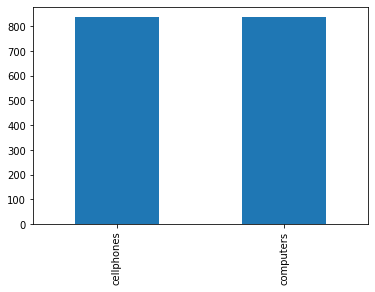

['apple', 'watch', 'soporte', 'teléfono']

In [14]:

# ------ Treat Unbalance data -------
Class_count=df['category'].value_counts().to_frame()

#create df of majority and minority class 
df_majority = df[(df['category_num']==1)] 
df_minority = df[(df['category_num']==0)] 

# Oversampling minority class
df_minority_ovsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= Class_count['category'][0], # match nb computers = nb celphones
                                 random_state=1)  # set a seed for reproducible results
# Concatenate both
df_ovsampled = pd.concat([df_minority_ovsampled, df_majority])

# plot
df_ovsampled['category'].value_counts().plot(kind='bar')
plt.show()


df.sample(frac=1) # shuffle the entire dataset
df = df_ovsampled #Using the oversample data increases classification accuracy


# --Splitting the dataset (train=80% test=20%)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
y_train = df_train["category"].values
y_test = df_test["category"].values


#--Remove stopwords--
stop_words=stopwords.words('spanish')
corpus= df_train["title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#---convert corpus into a list of lists of n-grams. 
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)
   
#Check
corpus.iloc[1]
lst_corpus[1]



In [15]:
#---Training my model using w2v---
vector_size = 300
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=vector_size,   
            window=8, min_count=1, sg=1, iter=100) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


dic[word]: 22 |idx
embeddings[idx]: (300,) |vector size
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 15, 300)           516600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 100)          140400    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 30)               13920     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 50)                1550      
                                                                 
 de

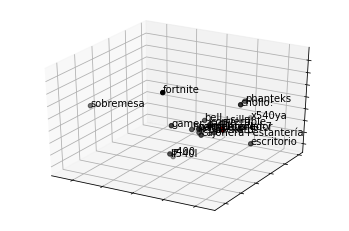

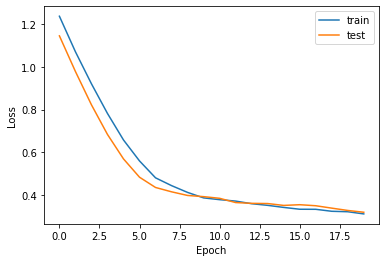

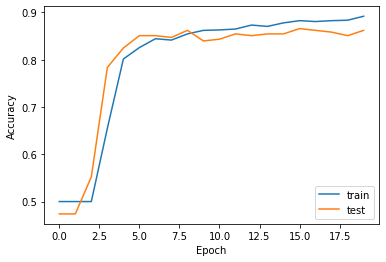

              precision    recall  f1-score   support

  cellphones       0.91      0.86      0.88       175
   computers       0.85      0.91      0.88       161

    accuracy                           0.88       336
   macro avg       0.88      0.89      0.88       336
weighted avg       0.89      0.88      0.88       336

Accuracy is:  0.8839285714285714
[[150  25]
 [ 14 147]]


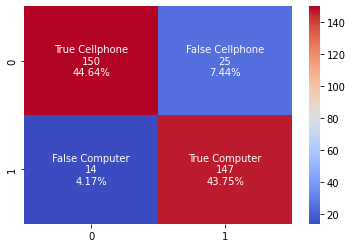

In [16]:
#Test-Convert word to vector using the model - check vector size
word = 'ordenador'
nlp.wv[word].shape  


#-- FIgure scatter of words
word = "ordenador"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.wv.most_similar(word, topn=20)]
X = nlp.wv[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)



#----Feature engineering---
#Transfor the list of lists of n-grams given to the Word2Vec into a 
# list of sequences:
    
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index # Make index for each word
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")


#-- do the same feature engineering on the test set as well:
#--Remove stopwords--
stop_words=stopwords.words('spanish')
corpus= df_test["title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
#corpus = df_test['title']


## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    

## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")


#---- Create matrix of embedding that will be used as a weight matrix 
#            in the neural network classifier

## start the matrix (length of vocabulary x vector size) 
embeddings = np.zeros((len(dic_vocabulary)+1, vector_size))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

#-test
word = "ordenador"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector size")



"""
===== NN structure ======
* 1 Embedding layer that takes the sequences as input and the word vectors as weights
* Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.
* Two final dense layers that will predict the probability of each news category.
"""

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(50, activation='sigmoid')(x)  #relu
y_out = layers.Dense(3, activation='softmax')(x)  

## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam', metrics=['accuracy']) 
model.summary()



#--Train the model and check the performance on a subset of the training set
# used for validation before testing it on the actual test set.

## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=20, shuffle=True, verbose=0, 
                     validation_split=0.2)  # epochs=10  20



#-- Figures Performance

plt.rcParams['text.color'] = 'black'
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(training.history['loss'], label="train")
plt.plot(training.history['val_loss'], label="test")
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.plot(training.history["accuracy"], label="train")
plt.plot(training.history["val_accuracy"], label="test")
plt.legend(loc='lower right')

plt.show()


## Prediction
predicted_prob = model.predict(X_test)
y_pred = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

print(classification_report(y_test.tolist(), y_pred))
print('Accuracy is: ',accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))





classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values


cf_matrix=confusion_matrix(y_test, y_pred)
group_names = ['True Cellphone','False Cellphone','False Computer','True Computer']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm') #Blues coolwarm rocket
    
